# Comparative Analysis Of YouTube Channels

### 1. Introduction
The goal of the project is to conduct comparative analysis of 3 YouTube channels that focus of perfornal finance: Graham Stephan, Andrei Jikh and Nate O'Brien. In this project, I offer a comprehensive analysis of channel performance and compare their content strategies. 

### 2. Dataset
I use YouTube API to collect necessary data for the analysis. The first step is to collect channels IDs, then for every channel ID I request video IDs that were published by the channel and finally, for every video ID, I get the following data:

  number of views \
  number of likes  \
  number of comments \
  categoryId \
  description \
  video duration \
  publishing date 
  

### 3. Data Preprocessing
To prepare the data for analysis I convert strings to an appropriate format. Publishing date is to be converted to the datetime format, number of views, likes and comments - to integers, video duration - to floats (minutes).

### 4. Views And Engagement Overview
In this section I analyze dynamics of monthly average views and ratios of number of likes and comments per views.
### 5. Analysis Of Video Duration And Publishing Strategy
Analysis of the distribution of video duration and publishing timing helps identify how bloggers optimize their content and utilize shorts to attract more views.
### 6. Analysis Of Tags and Titles
I identify the most commonly used tags to observe how channels' focus has changed over time and determine the words from titles that are likely to result in higher views.

In [31]:
#!pip install plotly
#!pip install wordcloud plotly

In [134]:
#importing the api key
from YOUTUBE_API_KEY import api_key

#Importing necessary packages
import requests
from tqdm import tqdm
import pandas as pd
import json
import re
import numpy as np

#libraries for visualizations
import plotly.express as px
from plotly.subplots import make_subplots
from IPython.display import display

#libraries for analysis of text data
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from collections import Counter
import string
from nltk.stem import PorterStemmer
from wordcloud import WordCloud
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings('ignore')

In [136]:
#color map is used to assign fixed color to a channel. I created a lot of visuals and want them to be consistent
color_map = {
    'Graham Stephan': 'red',
    'Andrei Jikh': 'blue',
    '''Nate O'Brien''': 'green'
             }
#when I refer to a channel, I can use a key instead of full channel title
names = {
   0: 'Graham Stephan',
   1: 'Andrei Jikh',
   2: '''Nate O'Brien'''
         }
#mapping between channel title and id
name_channelId = {
    'Graham Stephan': 'UCV6KDgJskWaEckne5aPA0aQ',
    'Andrei Jikh': 'UCGy7SkBjcIAgTiwkXEtPnYg',
    '''Nate O'Brien''': 'UCO3tlaeZ6Z0ZN5frMZI3-uQ'
    
                    }

In [137]:
#make sure to store the functions in a separate file!
def get_channel_video_ids(channel_id, api_key):
    
    '''
    Returns IDs of videos from a channel.
    
    channel_id - the id of a YouTube channel
    api_key - the API key to access YouTube API
    '''
    #the root endpoint of YouTube API
    base_url = 'https://www.googleapis.com/youtube/v3'
    
    url = f'{base_url}/channels'

    params = {
        "id": channel_id,
        "part": "contentDetails",
        "key": api_key
    }

    res = requests.get(url, params=params).json()
    
    # special playlist that is automatically created by YouTube for every channel to contain all its uploaded videos
    # we need to get the playlist id to collect all video ids
    playlist_id = res['items'][0]['contentDetails']['relatedPlaylists']['uploads']
    
    videos = []
    page_token = None
    
    while True:
        
        url = f'{base_url}/playlistItems'

        params = {
            "playlistId": playlist_id,
            "part": "snippet",
            "maxResults": 50,
            "key": api_key
        }
    # pageToken is a token or string that you use to request specific pages of data when the result set 
    # is too large to be returned in a single response.
        if page_token:
            params["pageToken"] = page_token

        res = requests.get(url, params=params).json()
        videos += res['items']
        page_token = res.get('nextPageToken')
        
        if not page_token:
            break

    return [video['snippet']['resourceId']['videoId'] for video in videos]



def get_video_stats(video_id, api_key):
        
    '''
    Returns statistics for a list of video ids.
    
    video_id - the id of a YouTube video
    api_key - the API key to access YouTube API
    '''
    url = "https://youtube.googleapis.com/youtube/v3/videos"
    params = {
              "key":api_key, 
              "part": "snippet, contentDetails, statistics", 
              "id":video_id
             }
    response = requests.request("GET", url, params=params).json()
    
    return response


def get_stats_for_channels(name_channelId, api_key):
    '''
    Returns a dictionary of the form:  {channel name 0: {
                                          video id 0: 
                                            video statistics, 
                                          video id 1:
                                            video statistics,
                                            ...
                                            },
                                         channel name 1: {...}}
    
    author_channelId - dict where keys are channel titles and values are channel IDs
    '''
    name_videoId = {}
    video_stats_dict = {}
    for name, channel_id in tqdm(name_channelId.items()):
        name_videoId[name] = get_channel_video_ids(channel_id, api_key)
        n_videos =  len(name_videoId[name])
        print(f'Number of videos of {name} is {n_videos}')

        for videoId in name_videoId[name]:
            video_stats = get_video_stats(videoId, api_key)
            video_stats_dict[videoId] = video_stats
            
    return video_stats_dict 


def save_dict_to_json(d, filename):
    with open(filename, 'w') as f:
        json.dump(d, f)
        

def print_charts(chart_list, height):
    '''
    Displays multiple charts one by one.
    
    chart_list - list of plotly charts
    '''
    fig = make_subplots(
                        rows=len(chart_list), 
                        cols=1, 
                        subplot_titles = [chart_list[i].layout.title.text for i in range(len(chart_list))]
                       )
                        
    # Add traces from fig1 to the subplot        
    for i, chart in enumerate(chart_list):
        for trace in chart['data'] :
            fig.add_trace(trace, row = i + 1, col = 1 )


    # Update layout to match the individual figures
    fig.update_layout(height=height) 
    fig.show()
    
    
#the funtion converts  duration of videos to minutes
def duration_to_minutes(duration_str):
    # Regular expression to extract hours, minutes, and seconds
    pattern = r'PT((?P<hours>\d+)H)?((?P<minutes>\d+)M)?((?P<seconds>\d+)S)?'
    
    match = re.match(pattern, duration_str)
    if not match:
        return None
    
    # Extract hours, minutes, and seconds
    hours = int(match.group('hours') or 0)
    minutes = int(match.group('minutes') or 0)
    seconds = int(match.group('seconds') or 0)
    
    # Convert everything to minutes
    total_minutes = hours * 60 + minutes + seconds / 60.0
    return total_minutes

In [138]:
def get_and_to_dataframe(name_channelId, api_key):
    
    '''
    The function accepts a channel id and api key and returns the output in pandas dataframe.
    You can use this function directly to get the dataframe instead of a raw json file.
    I showed the transformation from the raw request result to a dataframe in the video so that the process is more clear.
    '''
    result_dict = {}
    video_stats_dict = get_stats_for_channels(name_channelId, api_key)
    
    #modify the dictionary in order to keep the items you need for your analysis
    indicators = {
        'statistics': ['viewCount', 'likeCount', 'commentCount'],
        'snippet': ['channelTitle', 'publishedAt', 'tags', 'categoryId', 'title', 'description'],
        'contentDetails': ['duration']
    }

    for i in video_stats_dict.keys():
        video_info_dict = video_stats_dict[i]['items'][0]
        
        video_id = video_info_dict['id']
        
        video_data = {}

        for parent_key, attributes in indicators.items():
            for attribute in attributes:
                try:
                    if parent_key in video_info_dict:
                        video_data[attribute] = video_info_dict[parent_key].get(attribute, None)
                except Exception as e:
                    video_data[attribute] = None


        result_dict[video_id] = video_data
        data = pd.DataFrame(result_dict).T
        data['tags'] = data['tags'].apply(lambda x: [] if x is None else x)
    return data

In [139]:
data = get_and_to_dataframe(name_channelId, api_key)
data.head(3)

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

Number of videos of Graham Stephan is 953


 33%|███████████████████████████▋                                                       | 1/3 [01:59<03:58, 119.29s/it]

Number of videos of Andrei Jikh is 720


 67%|███████████████████████████████████████████████████████▎                           | 2/3 [03:29<01:41, 101.95s/it]

Number of videos of Nate O'Brien is 201


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [03:54<00:00, 78.16s/it]


,viewCount,likeCount,commentCount,channelTitle,publishedAt,tags,categoryId,title,description,duration
RtTe4NYgju0,139223,8889,926,Graham Stephan,2023-08-11T21:00:26Z,"[investing, investing for beginners, investing...",27,A Grim Warning For All Investors,"If you're interested, check out Policygenius: ...",PT11M31S
P8hbSpcb-Eo,174336,12316,1189,Graham Stephan,2023-08-07T22:00:24Z,"[investing, investing for beginners, investing...",27,why i stopped drinking alcohol,To start comparing quotes and simplify insuran...,PT12M10S
2Y1ysVfKnR0,369939,17121,1185,Graham Stephan,2023-07-31T22:30:00Z,"[investing, investing for beginners, investing...",27,Moving Back To California,Here's why people and businesses are beginning...,PT11M15S


In [40]:


'''
I used this code in the video to show the structure of the 'raw' file. In your project you whould use a function
such as get_and_to_dataframe to get the dataframe right away.

-----------the code----------
video_stats_dict = get_stats_for_channels(name_channelId, api_key)
save_dict_to_json(video_stats_dict, 'video_data_personal_finance.json')     
pretty_json = json.dumps(video_stats_dict['2Y1ysVfKnR0']['items'][0], indent=4)
print(pretty_json)

'''

{
    "kind": "youtube#video",
    "etag": "8XXrQPXHvkm6lP0VQhT41HSNS-0",
    "id": "2Y1ysVfKnR0",
    "snippet": {
        "publishedAt": "2023-07-31T22:30:00Z",
        "channelId": "UCV6KDgJskWaEckne5aPA0aQ",
        "title": "Moving Back To California",
        "description": "Here's why people and businesses are beginning to move back to California, why companies are eliminating \"work from home,\" and what this means for the future of the state - Enjoy! Add me on Instagram: GPStephan\n\nPROMOTIONAL OFFER: Get Up To 12 FREE STOCKS when you sign up and make a deposit using my paid affiliate link for WeBull: https://a.webull.com/i/GrahamStephan\n\nGET MY WEEKLY EMAIL MARKET RECAP NEWSLETTER: http://grahamstephan.com/newsletter\n\nTHE NEW PODCAST: https://www.youtube.com/channel/UCMSYZVlQmyG8_2MkIKzg0kw\n\nThe YouTube Creator Academy:  \nLearn EXACTLY how to get your first 1000 subscribers on YouTube, rank videos on the front page of searches, grow your following, and turn that into 

## Data Preprocessing

In this section we convert the values in the dataframe to the right format. Number of views, likes and comments should be converted into integers. Publishing date - to datetime and duration - to minutes.

In [140]:
data['publishedAt'] = pd.to_datetime(data['publishedAt'])
data['viewCount'] = data['viewCount'].fillna(0).apply(lambda x: int(x)) 
data['likeCount'] = data['likeCount'].fillna(0).apply(lambda x: int(x))
data['commentCount'] = data['commentCount'].fillna(0).apply(lambda x: int(x))
data['duration'] = data['duration'].apply(lambda t: duration_to_minutes(t))

Let's cut off the data for August 2023 since the month is not over yet.

In [141]:
data = data[data['publishedAt'] < '2023-08-01']

## Views And Engagement Analysis

1. Number of views
2. Engagement level (comments and likes as % of number of views)

These metrics allow us to compare how the channels perform relative to one another.

Let's first take a look at dynamics of number of views on every channel.

In [142]:
fig = px.line(data, x='publishedAt', y='viewCount', color='channelTitle', markers=True, \
              title='Bad Example: Number Of Views Per Day', color_discrete_map=color_map)

fig.update_layout(xaxis_title='Date', yaxis_title='Number of Views')
fig.show()

The Diagram 'Number Of Views Per Day' represents number of views per day for every channel. However, since the dataset is large and there are a few values that are significantly higher than the others, the diagram seems messy and it is hard to analyze the data and make conclusion about trends. Instead, let's calculate monthly averages of views to have a clearer picture.

In [143]:
data['year'] = data['publishedAt'].dt.year
data['month'] = data['publishedAt'].dt.month
data['year_month'] = pd.to_datetime(data[['year', 'month']].assign(DAY=1))

# Group by year and month and compute the average views
average_views_per_month = data.groupby(['channelTitle', 'year_month'])['viewCount'].mean().reset_index()

average_views_per_month.head(3)

,channelTitle,year_month,viewCount
0,Andrei Jikh,2019-01-01,41186.000000
1,Andrei Jikh,2019-02-01,435379.833333
2,Andrei Jikh,2019-03-01,184999.500000


In [144]:
fig = px.line(average_views_per_month, x='year_month', y='viewCount', color='channelTitle', \
              markers=True, title='Monthly Average Number of Views', color_discrete_map=color_map)
fig.update_layout(xaxis_title='Date', yaxis_title='Number of Views')
fig.show()

The diagram 'Monthly Average Number of Views' above allows us to clearly see data points and compare performance of the channels. 

The channels performed competitively until 2022. But since July 2022 Graham Stephan started to significantly outperform his main competitors. Since that time his videos gained, on average, from 500k to 4m views every month. It would be interesting to divee deeper into how his content changed and which strategies he used to reach such levels of views.

The two other channels show decreasing trend in 2023.

To check if the traffic is real was not generated by bots, we can check the engagment expressed as a ratio of comments & likes per view. These ratios show how active the audience of the channel is, and it is one of the crucial factor to consider when you choose a blogger to market your product, for example.

In [145]:
data['comments_to_views'] = data['commentCount']/data['viewCount']
data['likes_to_views'] = data['likeCount']/data['viewCount']


# Group by year and month and compute the average comments & likes per view ratio
average_engagement_per_month = data.groupby(['channelTitle', 'year_month'])['comments_to_views', 'likes_to_views'].mean().reset_index()

In [146]:
fig1 = px.line(average_engagement_per_month, x='year_month', y='comments_to_views',\
               color='channelTitle', markers=True, title='Monthly Average Comments-Per-View Ratio', color_discrete_map=color_map)
fig2 = px.line(average_engagement_per_month, x='year_month', y='likes_to_views', \
               color='channelTitle', markers=True, title='Monthly Average Likes-Per-View Ratio', color_discrete_map=color_map)


print_charts([fig1, fig2], 600)

Ratio of comments and likes per view of Graham Stephan has been decreasing since 2021, but is currently comparable with his competitors. He seems to attracked more viewers who are less engaged.  The trend is generally decreasing. The same can said about the channel of Andrei Jikh. 

Nate O'Brien reached higher comments-to-view ratio in 2023, while views are decreasing. That might happen because he started to publish more niche content for more narrow audience who is more responsive to certain topics.

Engagement on the channel of Andrei Jikh is the lowest in 2023.

In the next sectiosn we'll try to respond to the following questions that we formulated previously:
1. Which content strategy allowed Graham Stephane to get so many views in 2023?
2. How Nate O'Brien achieved higher engagement?

## Technical characteristics of content

In this section we will analyse technical characteristics of content such as video duration, publishing frequency and schedule. These can impact number of views, viewer engagement, retention, and channel growth.


### Number Of Videos And Duration
We will calculate video duration and publishing frequency on monthly basis.

In [147]:
average_duration_month = data.groupby(['channelTitle', 'year_month'])['duration'].mean().reset_index()
average_videos_month = data.groupby(['channelTitle', 'year_month'])['title'].count().reset_index().rename(columns = {'title': 'n_videos'})

In [148]:
channelTitlefig1 = px.line(average_videos_month, x='year_month', y='n_videos',\
               color='channelTitle', markers=True, title='Monthly Average Number Of Videos', color_discrete_map=color_map)
fig2 = px.line(average_duration_month, x='year_month', y='duration', \
               color='channelTitle', markers=True, title='Monthly Average Video Duration (Minutes)', color_discrete_map=color_map)


print_charts([fig1, fig2], 600)

Nate O'Brien produces 1-3 videos per month, but he focuses on longer videos than his competitors. Focus on more profound content might have led to high viewer engagement that we indicated in the previous section. Graham Stephan and Andrei Jikh focus on shorter and more frequenty published videos. However, if Graham Stephan views per month skyrocketed in 2023, Andrei Jikh experienced a decline in his views.

If you look at the distribution of video duration of these two channels, you'll see that 2/3 of Andrei's content are shorts, while Graham keeps balance: only 1/3 of his content are shorts.

In [149]:
fig2023 = px.histogram(data[(data['channelTitle'] == names[0]) & (data['year'] == 2023)], \
                   x='duration', title=f"Distribution of Video Duration in 2023, {names[0]}", nbins=15)

fig2022 = px.histogram(data[(data['channelTitle']== names[0]) & (data['year'] == 2022)], \
                   x='duration', title=f"Distribution of Video Duration in 2022, {names[0]}", nbins=15)

print_charts([fig2023, fig2022], 600)

In [150]:
fig2023 = px.histogram(data[(data['channelTitle'] == names[1]) & (data['year'] == 2023)], \
                   x='duration', title=f"Distribution of Video Duration in 2023, {names[1]}", nbins=15)

fig2022 = px.histogram(data[(data['channelTitle'] == names[1]) & (data['year'] == 2022)], \
                   x='duration', title=f"Distribution of Video Duration in 2022, {names[1]}", nbins=15)

print_charts([fig2023, fig2022], 600)

### Publishing Schedule
Now let's analyse the publishign timing of these bloggers. We'll extract hour from publishing time adn then build a heatmap to see when they publish their videos.

In [151]:
# Extract hour
data['date'] = data['publishedAt'].dt.date
data['hour'] = data['publishedAt'].dt.hour

def create_heatmap(years, channel_name):
    
    pivot = data[(data['year'].isin(years)) & (data['channelTitle'] == channel_name )]. \
    pivot_table(index='hour', columns='date', aggfunc='size', fill_value=0)
    
    fig = px.imshow(pivot, labels=dict(x="Date", y="Hour", color="Frequency"), 
                title = f"Publishing Hour Over Time ({channel_name})")
    
    return fig

print_charts( [create_heatmap([2022, 2023], name) for name in data['channelTitle'].unique()], 700)

We can see that Graham Stephan does not stick to strict time, which probably allows him to target audience that live in places with different time zones, which eventually leads to higher views. Andrei Jikh publishes almost all his videos strictly at 22h (CET).

## Content Analysis

### Most Used Tags
The quickest way to understand the topics covered by a channel is by creating an overview of its tags. It does not require any text preprocessing techniques as we allready collected tags in lists.


In [152]:
def top_tags_by_year(data, channel_title, n_tags):
    '''
    get top 7 tags used in videos in a corresponding
    '''
    # Flatten the list of tags by year and count occurrences
    selected = data[data['channelTitle'] == channel_title]
    all_tags = selected.explode('tags').groupby(['year', 'tags']).size().reset_index(name='count')

    # Sort and filter out the top 5 tags for each year
    top_tags = all_tags.groupby('year').apply(lambda x: x.nlargest(n_tags, 'count')).reset_index(drop=True)

    # Create a pivot table with years as columns and top tags as rows
    pivot_table = top_tags.pivot_table(index=top_tags.groupby('year').cumcount(), columns='year', values='tags', aggfunc='first')

    print(f"Top 5 Tags By Year for {channel_title}")
    return pivot_table


In [153]:
for n in range(len(names)):
    display(top_tags_by_year(data, names[n], n_tags = 7))

Top 5 Tags By Year for Graham Stephan


year,2017,2018,2019,2020,2021,2022,2023
0,tai lopez,real estate agent,how to invest,investing for beginners,best stock trading app,passive income,best stock trading app
1,grant cardone,real estate investing,real estate investing,how to invest,credit card,best stock trading app,credit cards for beginners
2,real estate investing,how to invest in real estate,how to invest in real estate,how to invest in stocks,credit cards for beginners,credit card,credit score
3,how to invest in real estate,real estate 101,how to invest in stocks,how to invest in real estate,how to be a millionaire,credit cards for beginners,credit score explained
4,real estate agent,real estate investing 101,how to make passive income,credit score,how to be a millionaire in 3 years,credit score,how to be a millionaire
5,how to make money in real estate,real estate investing for beginners,passive income ideas,how to be a millionaire,how to invest,credit score explained,how to be a millionaire in 3 years
6,gary vee,grant cardone,investing for beginners,robinhood,how to invest in real estate,how to be a millionaire,how to build wealth


Top 5 Tags By Year for Andrei Jikh


year,2019,2020,2021,2022,2023
0,andrei jikh,investing for beginners,passive income,best investment,andrei jikh
1,dividends,andrei jikh,investing,best stock trading app,best investment
2,dividend stocks,how to invest,best stock trading app,best trading app,best stock trading app
3,robinhood app,robinhood app,andrei jikh,bitcoin,best trading app
4,stock market,how to invest in stocks,dividend stocks,credit score,bitcoin crash
5,passive income,robinhood,dividends,crypto,credit score
6,robinhood,how to be a millionaire,investing for beginners,cryptocurrency,crypto crash


Top 5 Tags By Year for Nate O'Brien


year,2017,2018,2019,2020,2021,2022,2023
0,invest,nate obrien,nate o'brien,nate o'brien,nate o'brien,nate o'brien,nate o'brien
1,stocks,money,how to save money,nate obrien,investing for beginners,stock market,how to invest
2,affiliate,make money,save money,stock market,book recommendations,investing,investing for beginners
3,affiliate marketer,nate o'brien,money,investing,investing 101,passive income,stock market
4,affiliate marketing,make money online,saving money,personal finance,investing in stocks for beginners,stock market crash,how investing works
5,affiliate marketing amazon,investing,nate obrien,how to invest,nate obrien,best dividend stocks,how to invest in stocks
6,affiliate marketing for beginners,best jobs,how to invest,stocks,passive income,dividend investing,how to invest in the stock market


We can clearly see that all the bloggers started to use more general tags that appeal to wider audiencce than in the beginning.

### Titles Of The Most Watched Videos
Let's first take a look at the titles of videos that gained the biggest number of views. That allow to understand which topics are more appreciated by their viewers.

In [154]:
# Sort and get top 10 (or less if less than 10 videos) videos for each channel
top_videos = data[['channelTitle', 'title', 'viewCount']].sort_values(['channelTitle', 'viewCount'], ascending=[True, False]) \
               .groupby('channelTitle').head(10)

# Pivot the table to get desired structure
pivot_df = top_videos.set_index(['channelTitle', top_videos.groupby('channelTitle').cumcount()]).unstack(0)

# Display the result
pivot_df

title  \
channelTitle                                        Andrei Jikh   
0             Now You See Me VS REAL LIFE (CARD SCENE RECREA...   
1              The Best Metaverse Investment #shorts #Metaverse   
2                             The Dollar Is Going To $0 #shorts   
3                             How Banks Can Print Money #shorts   
4                      How I Met A Dogecoin Millionaire #shorts   
5                 How The Dollar Lost 99% Of It's Value #shorts   
6                   How The Stock Market Actually Works #shorts   
7               7 Passive Income Ideas - How I Earn $700 A Day!   
8                                   How To Invest For Teenagers   
9                                 Stock Market Fun Fact #shorts   

                                                               \
channelTitle                                   Graham Stephan   
0                          How Michael Reeves Learned To Code   
1                        How Much Money Michael Reeves Spends   
2             From Homeless To Owning A Bugatti | TheStradman   
3                How The Dogecoin Millionaire LOST $3 MILLION   
4                                Kevin O'Leary Gets Triggered   
5                      How I bought a Tesla for $78 Per Month   
6                           Why Ludwig Got FIRED From His Job   
7                      The WORST Shark Tank Pitch Of All Time   
8                                     Why I Evicted My Tenant   
9                            Touring Michael Jordan’s Mansion   

                                                                  viewCount  \
channelTitle                                       Nate O'Brien Andrei Jikh   
0             10 Legit Ways To Make Money As a Teenager [In ...    26208857   
1             Passive Income: How I Make $7,200 A Month (5 W...    10798996   
2             Stock Market For Beginners | How To Invest (St...     7337858   
3             Stock Market For Beginners 2021 | How To Inves...     5996369   
4                                       My Minimalist Apartment     3917447   
5             7 Places Your Money Needs To Go (How To Save M...     3758473   
6                        7 Side Jobs To Make Extra Money (2019)     3416323   
7             Money Saving Tips || How To Save Money (Best S...     3113513   
8                     5 Millionaire Habits That Changed My Life     2951055   
9             10 Things I Stopped Buying (Minimalism + Savin...     2803721   

                                          
channelTitle Graham Stephan Nate O'Brien  
0                  43252730      3584659  
1                  30716294      3457171  
2                  23339871      3228191  
3                  14795697      3161515  
4                  14456654      2845498  
5                   8554966      2725824  
6                   7848419      2082513  
7                   6803455      1966095  
8                   6787114      1923277  
9                   6567192      1821944

The most successfull videos of Andrei are about some hype topics. Graham Stephan's videos are rather entertaining, he focused on spicy stories of success and failure. Nate O'Brien seems to be the only guy whose content may be called kind of educational.

### Words Ranked By Views 
Here, we select words that are most commonly used in video titles that got the highest number of views. Thus, we can identify which words a creator should use to maximize their views.


In [155]:

def rank_words_by_views(titles, view_counts, stop_words=[]):
    '''
    The function splits video titles into separate words, removes punctuation and stop words, and extracts word stems. 
    It returns a list of word stems along with the number of views of videos that had titles containing each word.
    
    titles - array of titles
    view_counts - array of number of views
    stop_words - the list of words to be excluded
    '''
    
    ps = PorterStemmer()
    translator = str.maketrans('', '', string.punctuation)
    words = [ps.stem(word) for title in titles for word in title.translate(translator).lower().split() \
                                                                            if word not in stop_words]
    word_views = Counter({word: 0 for word in words})
    
    for title, count in zip(titles, view_counts):
        for word in set(title.translate(translator).lower().split()):
            stemmed_word = ps.stem(word)
            if stemmed_word in word_views:
                word_views[stemmed_word] += count
                
    infrequent_words = [word for word, count in Counter(words).items() if count < 5]
    for word in infrequent_words:
        del word_views[word]

    sorted_words, sorted_word_counts = zip(*word_views.most_common())
    return list(sorted_words), np.array(sorted_word_counts)


# Generate word cloud
def generate_word_cloud(words, counts):
    '''
    the function generates a diagram with word cloud.
    
    words - array of words
    counts - array of numerical values (views in our case)
    
    '''
    word_freq = {word: count for word, count in zip(words, counts)}
    wc = WordCloud(width=800, height=400, background_color="white", colormap="viridis").generate_from_frequencies(word_freq)
    
    # Display using matplotlib
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.show()


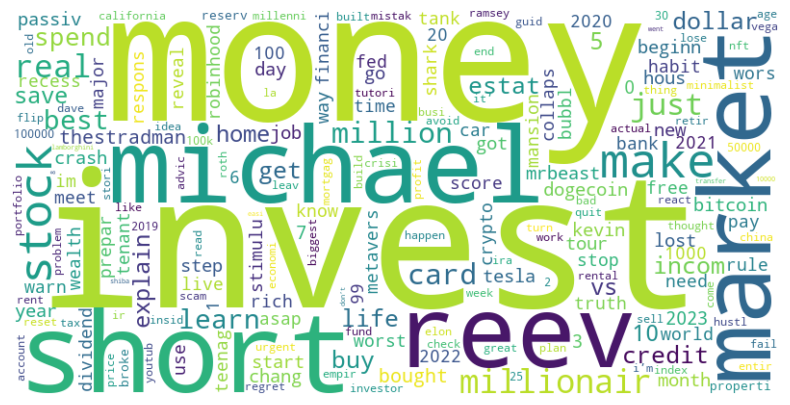

In [156]:
top_words, top_counts = rank_words_by_views(data['title'].values, data['viewCount'].values, stop_words=ENGLISH_STOP_WORDS)
generate_word_cloud(top_words, top_counts)

###  Title/Descriptions Length And Number Of Tags

Let's look at the number of tags and lenght of title and description. These are fectors that are taken into account by YouTube algorithm.

In [157]:
#calculating lengths of title, description and list of tags
data['title_length'] = data['title'].apply(lambda x: len(x)) 
data['description_length'] = data['description'].apply(lambda x: len(x))
data['tags_length'] = data['tags'].apply(lambda x: len(x))

In [158]:
fig_tags = px.scatter(data, x='date', y='tags_length',\
                      color='channelTitle', title='Number Of Tags Per Video',  color_discrete_map=color_map)
fig_title = px.scatter(data, x='date', y='title_length',\
                      color='channelTitle', title='Length Of Title Per Video', color_discrete_map=color_map)
fig_description = px.scatter(data, x='date', y='description_length',\
                      color='channelTitle', title='Length Of Description Per Video', color_discrete_map=color_map)



print_charts( [fig_tags, fig_title, fig_description], 700)

The first thing that sticks out is that Graham Stephan took Youtube algorithm seriously: just looks atthe red line on the first diagram (Number Of Tags Per Video). It looks like Graham was experimenting a lot with number of tags and finally found the perfect number which is 22. It seems that Andrei Jikh also did that kind of experiments, but in his case it is not likely that it has dramatic effect on his views as we know that his average monthly views all actually declining.Videos of Nate O'Brien tend to have very few tags, which is not beneficial for search. I would definitely recommend him to add more tags.

Let's look at the title. All the bloggers tend to set title of 30-60 characters. I assume it happens because in that case the title is displayed fully on all devices.

As for the description, Graham Stephan uses between 3k and 4k of words, but it may be because of affiliated links, advertising, etc. 

### Conclusion


The channel of Graham Stephane is currently the most successful among the three channels in terms of growth and number of views. He managed to outperform his competitors in terms of views by targeting wider audience, balancing content between regular videos and shorts and optimizing his videos for search algorithms. However, his audience became less engaged and active. 

Andrei Jikh is experiencing a decline in average number of views and viewer engagement because he produces too much of short content, and he might increase number of longer videos to revert this trend.

Nate O'Brien could on the other hand start using short videos to attract more audience for his videos and improve his search strategy by adding more tags.